In [151]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [141]:
# Load the dataset and display the number of rows and columns
df = pd.read_csv('/content/heart.csv', delimiter=',')
df.dataframeName = 'heart.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1025 rows and 14 columns


In [143]:
# View a couple rows of the dataset
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [179]:
'''
This code block contains functions for visualizing the data. Visualization is an
important building block of introducing eXplainable AI into the medical field.
'''
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    n_unique = df.nunique()
    df = df[[col for col in df if n_unique[col] > 1 and n_unique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = math.ceil(nCol / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df):
    # filename = df.dataframeName
    # Drop columns with NaN values
    df = df.dropna(axis='columns')  # Specify axis='columns' to drop columns with NaN
    # Keep columns where there are more than 1 unique value
    df = df[[col for col in df if df[col].nunique() > 1]]

    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    graphWidth = 8
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for Heart Disease Data', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df):
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')  # Specify axis='columns' to drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique values

    columnNames = list(df)
    if len(columnNames) > 10:  # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    plotSize = 20
    textSize = 10
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(corrs, k=1)):
        ax[i, j].annotate(f'Corr. coef = {corrs[i, j]:.3f}', (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)

    plt.suptitle('Scatter and Density Plot')
    plt.show()

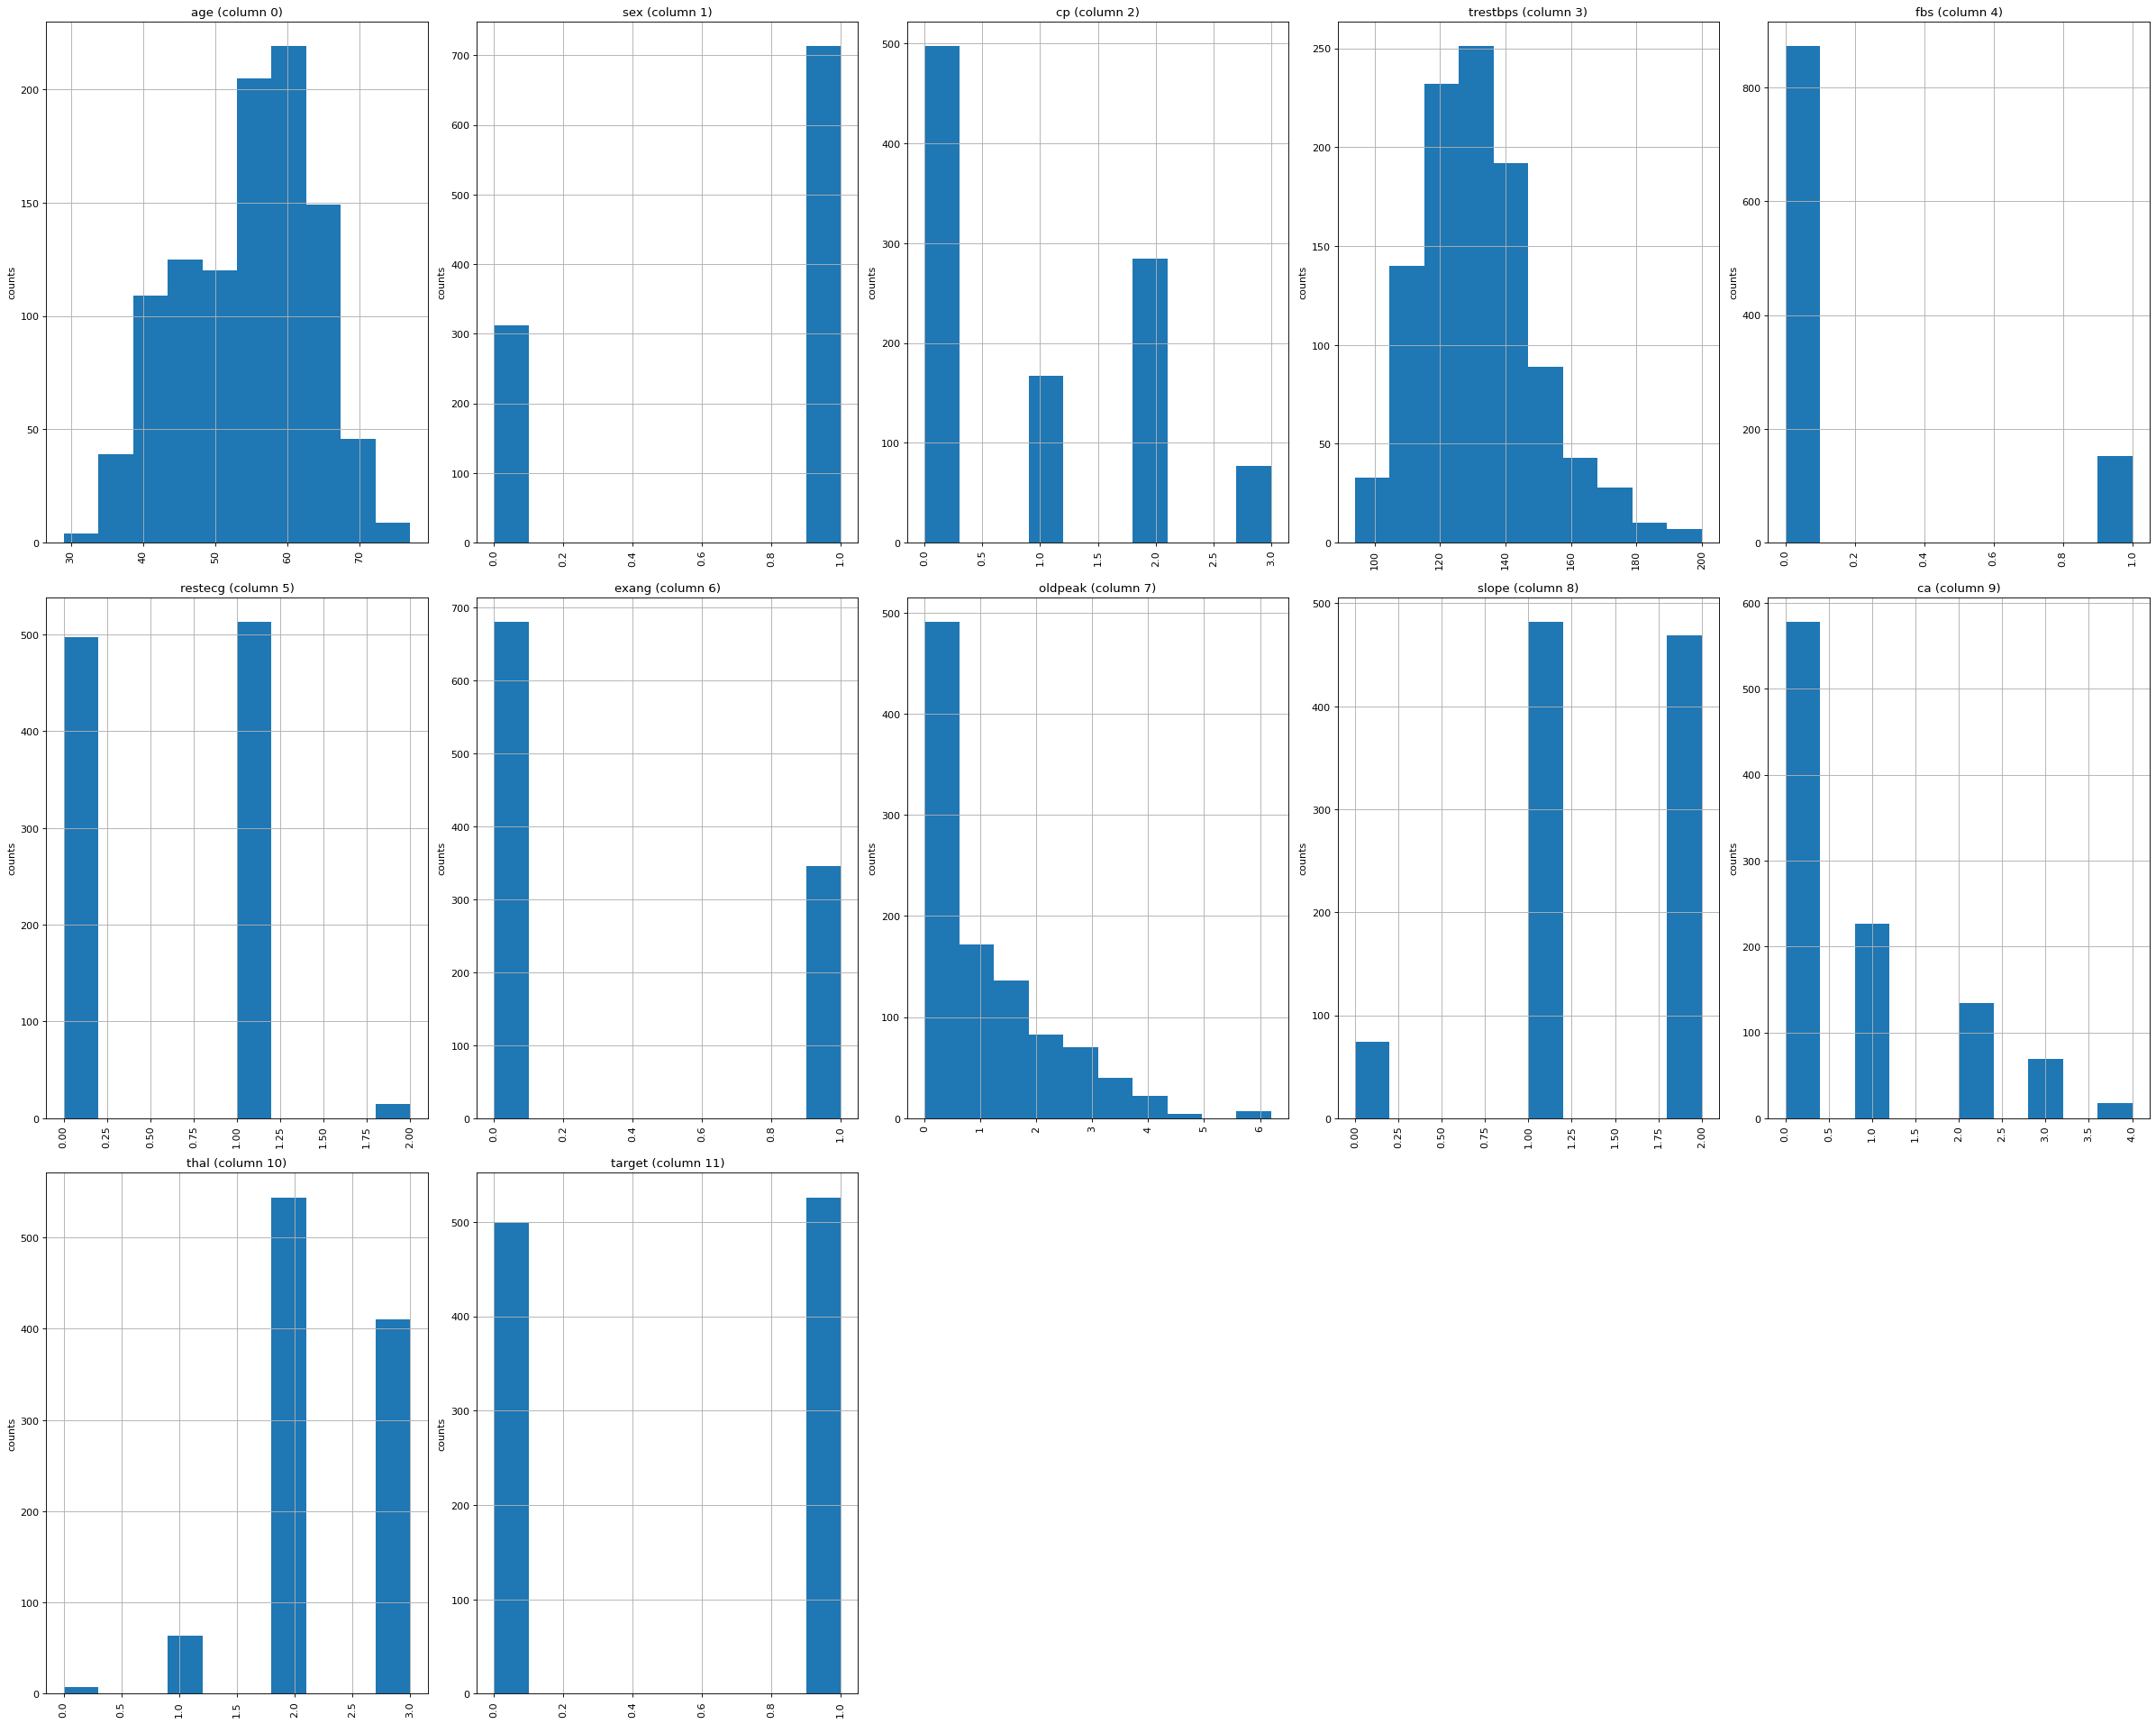

In [146]:
# Display distribution graphs
plotPerColumnDistribution(df, 14, 5)

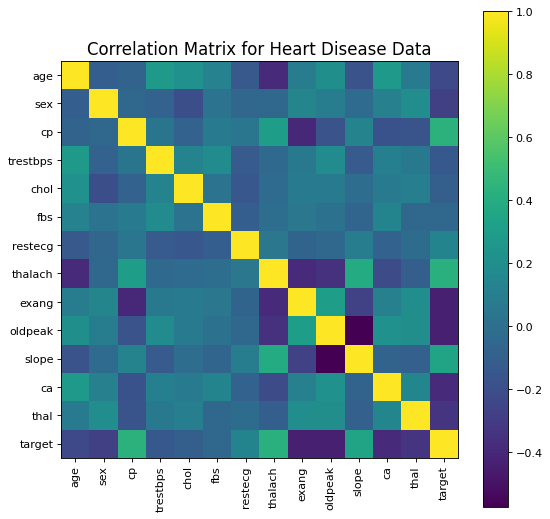

In [180]:
plotCorrelationMatrix(df)

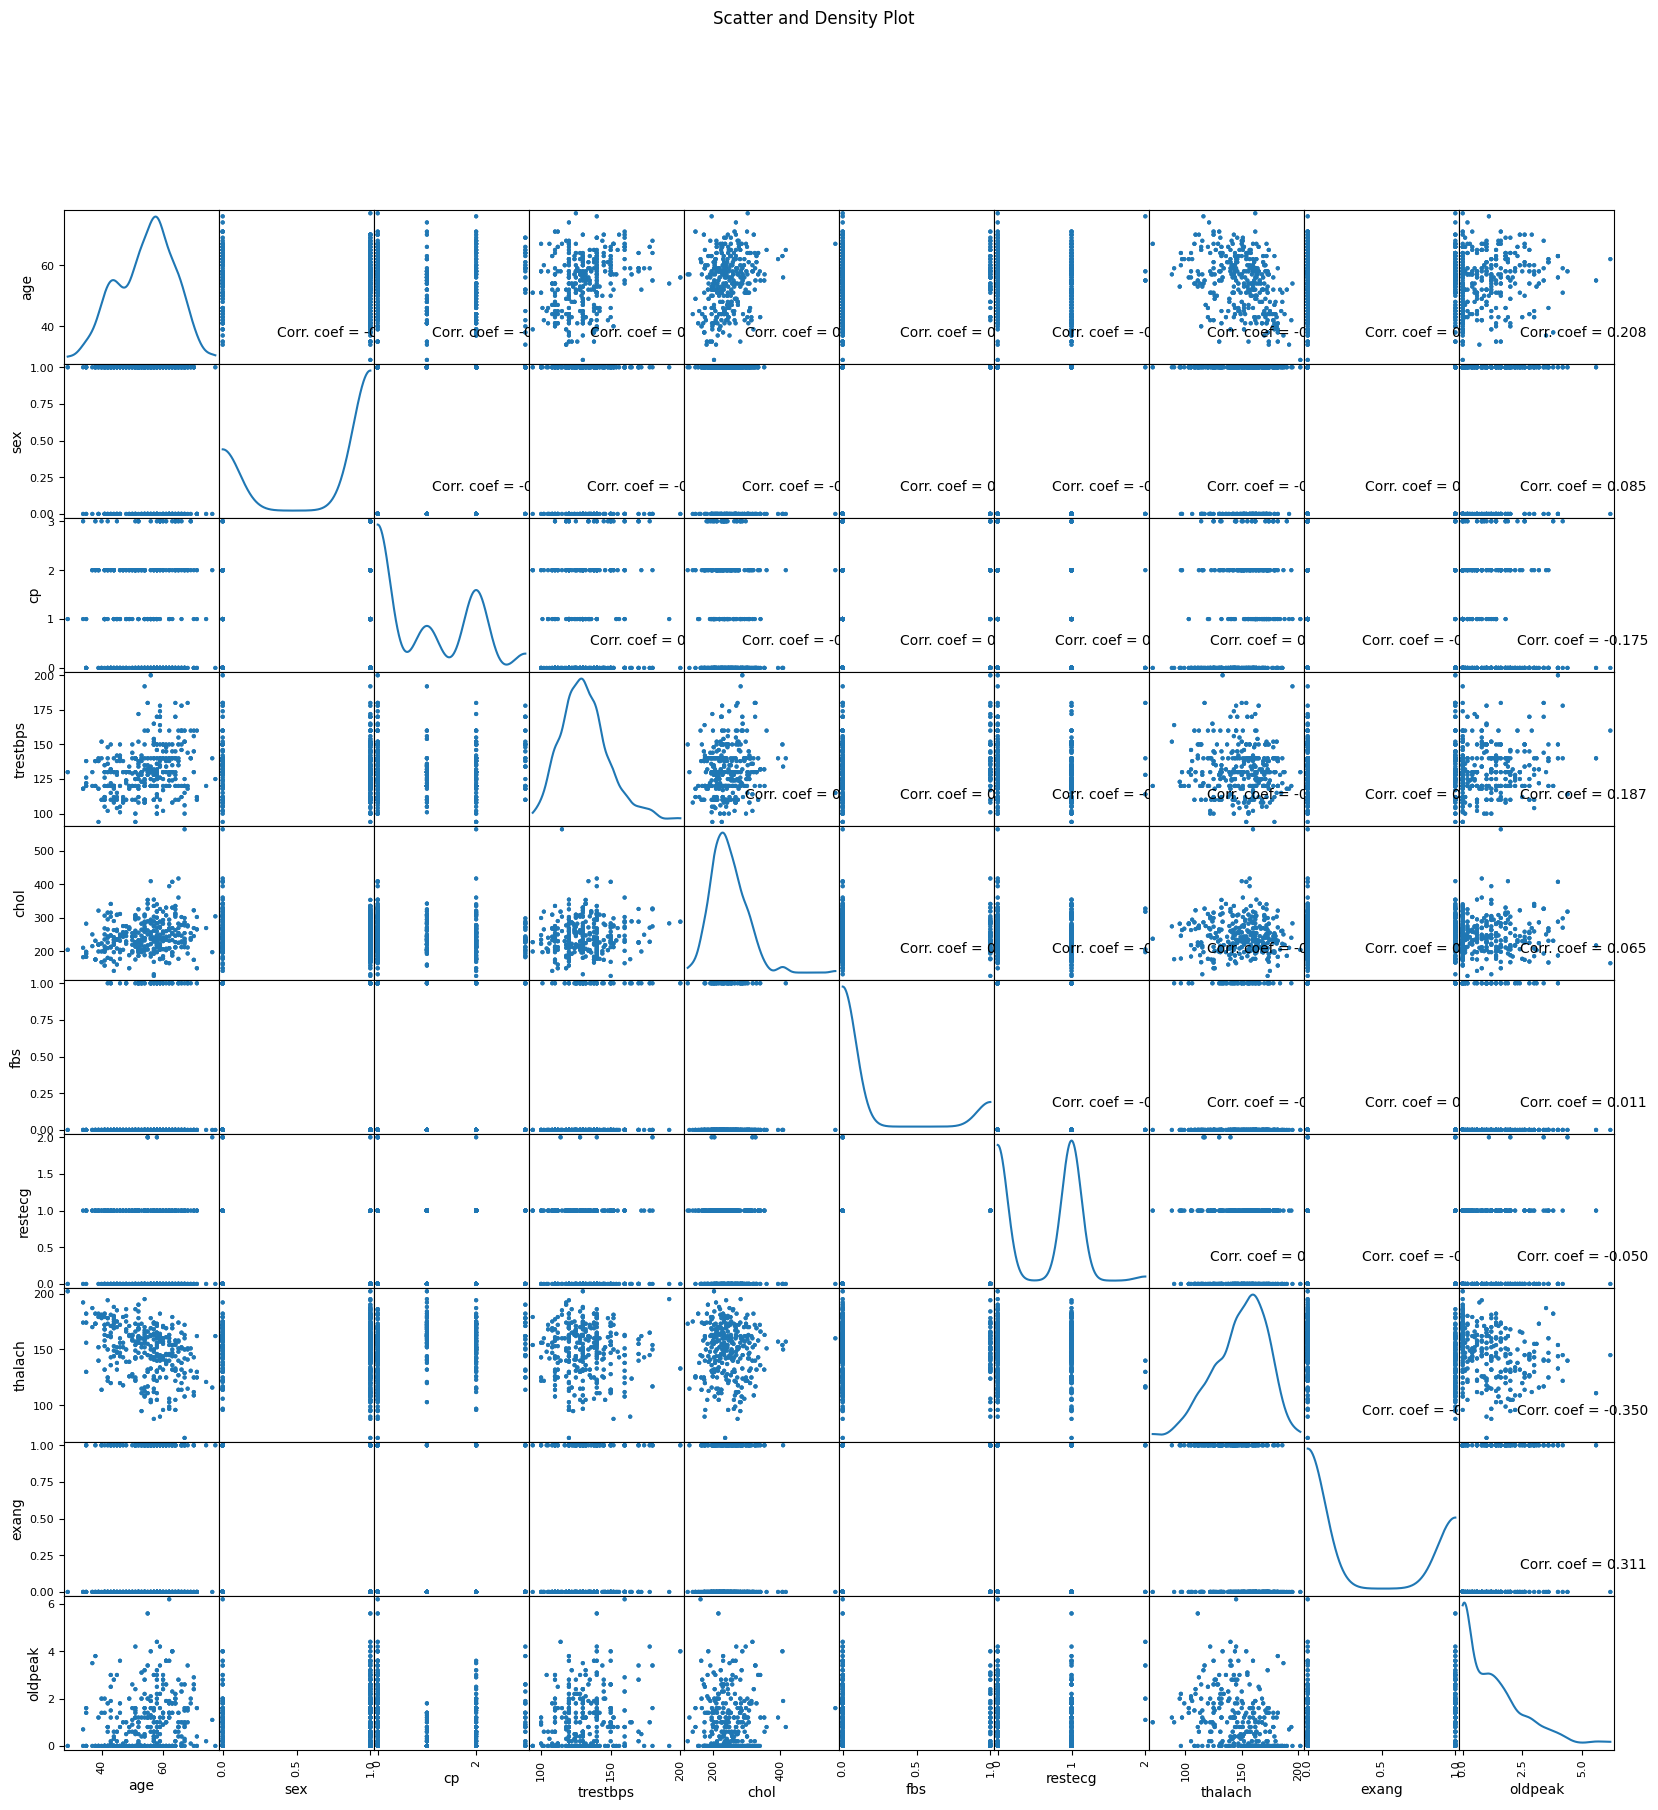

In [147]:
plotScatterMatrix(df)

In [ ]:
# Now we can begin processing the data for training
# Split the cleaned data
X = df.drop(columns=['target'])
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [160]:
# k Nearest Neigbors model
def train_knn(x_train, y_train, x_test, y_test, n_neighbors=5):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'K-Nearest Neighbors performance:')
    evaluate_model(y_test, y_pred)

In [157]:
# Logistic regression model
def train_logistic_regression(x_train, y_train, x_test, y_test):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Logistic Regression performance:')
    evaluate_model(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

In [189]:
# Random forest model
def train_random_forest(x_train, y_train, x_test, y_test, n_estimators=100):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Random Forest (n_estimators={n_estimators}) performance:')
    evaluate_model(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

In [174]:
# Support vector machine model
def train_svm(x_train, y_train, x_test, y_test):
    model = SVC(kernel='linear', random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'SVM performance:')
    evaluate_model(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

In [161]:
# Function to evaluate the model performance
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    return accuracy, precision, recall, f1


In [162]:
train_knn(x_train, y_train, x_test, y_test, n_neighbors=5)

K-Nearest Neighbors performance:
Accuracy: 0.7317073170731707
Precision: 0.7307692307692307
Recall: 0.7378640776699029
F1 Score: 0.7342995169082126


In [163]:
train_logistic_regression(x_train, y_train, x_test, y_test)

Logistic Regression performance:
Accuracy: 0.7951219512195122
Precision: 0.7563025210084033
Recall: 0.8737864077669902
F1 Score: 0.8108108108108109


In [190]:
train_random_forest(x_train, y_train, x_test, y_test)

Random Forest (n_estimators=100) performance:
Accuracy: 0.9121951219512195
Precision: 0.9047619047619048
Recall: 0.9223300970873787
F1 Score: 0.9134615384615384


In [175]:
train_svm(x_train, y_train, x_test, y_test)

SVM performance:
Accuracy: 0.8048780487804879
Precision: 0.7560975609756098
Recall: 0.9029126213592233
F1 Score: 0.8230088495575221


In [ ]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, cv=5)
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Cross-Validation Accuracy:", scores.mean())

Cross-Validation Accuracy Scores: [1.         1.         1.         1.         0.98536585]
Mean Cross-Validation Accuracy: 0.9970731707317073


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [181]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
rf_model.fit(x_train, y_train)
print("Random Forest Performance after adjusting parameters:")
evaluate_model(y_test, rf_model.predict(x_test))

Random Forest Performance after adjusting parameters:
Accuracy: 0.9853658536585366
Precision: 1.0
Recall: 0.970873786407767
F1 Score: 0.9852216748768473


(0.9853658536585366, 1.0, 0.970873786407767, 0.9852216748768473)

In [182]:
feature_importances = rf_model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

age: 0.0772
sex: 0.0365
cp: 0.1300
trestbps: 0.0642
chol: 0.0852
fbs: 0.0103
restecg: 0.0167
thalach: 0.1166
exang: 0.0655
oldpeak: 0.1165
slope: 0.0557
ca: 0.1233
thal: 0.1022
